Referencias:

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from IPython.display import Math

# Definición del problema

In [2]:
env = gym.make('FrozenLake-v0')
print(env.observation_space.n)
print(env.action_space.n)
env.render()

16
4

SFFF
FHFH
FFFH
HFFG


- S: punto de partida
- F: Frozen (Hay hielo y puedo pisar sin caerme)
- H: Hole (Hay un agujero)
- G: Goal (Punto de llegada)

In [3]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

In [22]:
# Defino un juego que no patina
env_not_slippery = gym.make('FrozenLakeNotSlippery-v1')

In [5]:
# 0 -> Left
# 1 -> Down
# 2 -> Right
# 3 -> Up
holes = (np.array([1,1,2,3]),np.array([1,3,3,0]))
controls = []
controls.append('L')
controls.append('D')
controls.append('R')
controls.append('U')
controls = np.array(controls)

action = {action:i for i, action in enumerate(controls)}

In [6]:
s0 = env.reset()

In [7]:
s1,r,d,prob = env.step(action['L'])
print(s1,r,d,prob)
env.render()

4 0.0 False {'prob': 0.3333333333333333}
  (Left)
SFFF
FHFH
FFFH
HFFG


In [8]:
i = 10
np.random.randn(1,env.action_space.n)*(1./(i+1))

array([[-0.175937  ,  0.08152868, -0.12995632,  0.05594   ]])

# Table

In [9]:
def estimate_Q(env, num_episodes = 500, lr = .8, y = .95, MA_window = 200, debug = False):
    #lr -> Learning rate
    #y -> Discounted reward coeficient
    #num_episodes -> Iterations
    #MA_window -> Moving Average window for averaging rewards
    
    #Initialize table with all zeros
    Q = np.zeros([env.observation_space.n,env.action_space.n])
    # Set learning parameters
    #create lists to contain total rewards and steps per episode
    #jList = []
    rList = []

    acummulated_average = []
    
    for i in range(num_episodes):
        started = False
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Table learning algorithm
        while j < 99:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a)
            #Update Q-Table with new knowledge
            # np.max(Q[s1,:]) -> Cual de todas las acciones tiene mayor valor cuando estoy en el esstado 
            # r + y*np.max(Q[s1,:]) -> Estimated discounted reward
            Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])

            rAll += r
            if debug:
                if (Q[s,a]>0) & (not started):
                    print('episode:',i)
                    started=True
                if started:
                    print('desde:',s,', hasta:',s1,', accion:',controls[a],', Q:', Q[s,a], ', reward:',r)
                    if d:
                        print('Finish!:', rAll)
            s = s1
            if d == True:
                break
        #jList.append(j)
        rList.append(rAll)
        acummulated_average.append(float(sum(rList[-MA_window:]))/MA_window)
    return Q, acummulated_average, rList

In [10]:
def plot_policy(Q):
    zero_Q = np.sum(Q, axis = 1).reshape(4,4) == 0
    policy = np.array(controls)[np.argmax(Q, axis=1)].reshape(4,4)
    policy[zero_Q] = 'X'
    policy[holes] = 'H'
    print(policy)
    
def show_results(Q, acummulated_average):
    plt.plot(acummulated_average)
    plt.xlabel('Episodes')
    plt.ylabel('Wining Average')
    plt.show()
    display(Math('$Q(s_i,a_j)$'))
    print(Q)
    display(Math('$V(s_j) = max_{a_j} Q(s_i,a_j)$'))
    print(np.max(Q, axis=1).reshape(4,4))
    display(Math('$a_j = \pi(s_i) = argmax_{a_j} Q(s_i,a_j)$'))
    plot_policy(Q)

## Non-Slippery
### y=1, lr =1

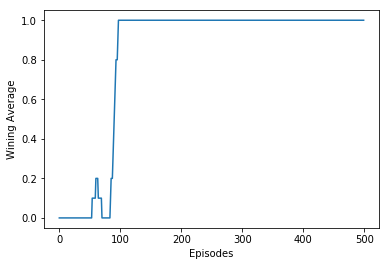

<IPython.core.display.Math object>

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


<IPython.core.display.Math object>

[[1. 1. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


<IPython.core.display.Math object>

[['R' 'R' 'D' 'X']
 ['X' 'H' 'D' 'H']
 ['X' 'X' 'D' 'H']
 ['H' 'X' 'R' 'X']]


In [11]:
num_episodes = 500
Q_ns_table, acummulated_average_ns_table, rList = estimate_Q(env_not_slippery, 
                                                             num_episodes=num_episodes, 
                                                             y = 1, MA_window = 10, 
                                                             debug=False, 
                                                            lr = 1)
show_results(Q_ns_table, acummulated_average_ns_table)

### y=1, lr =0.01

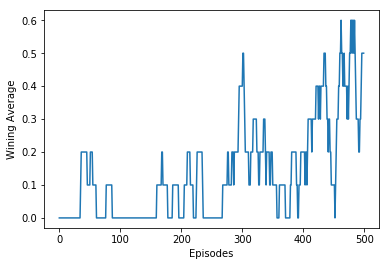

<IPython.core.display.Math object>

[[3.96036729e-05 2.68399671e-05 1.28049349e-04 4.02572866e-05]
 [2.10334634e-05 0.00000000e+00 3.98945440e-04 6.64936250e-05]
 [1.72782028e-05 2.76353318e-03 3.98870635e-06 1.87176382e-04]
 [8.92910327e-05 0.00000000e+00 2.15104686e-06 9.16213061e-07]
 [1.39037780e-05 7.53795950e-05 0.00000000e+00 2.32604173e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.20088688e-02 0.00000000e+00 2.42504474e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.54726598e-05 0.00000000e+00 4.88986390e-04 5.34340066e-06]
 [4.53522839e-06 4.32037721e-04 9.51293619e-03 0.00000000e+00]
 [1.29280896e-06 1.49217353e-01 0.00000000e+00 1.79651061e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.57977486e-02 7.86089800e-08]
 [0.00000000e+00 0.00000000e+00 5.10109727e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

<IPython.core.display.Math object>

[[1.28049349e-04 3.98945440e-04 2.76353318e-03 8.92910327e-05]
 [7.53795950e-05 0.00000000e+00 2.20088688e-02 0.00000000e+00]
 [4.88986390e-04 9.51293619e-03 1.49217353e-01 0.00000000e+00]
 [0.00000000e+00 1.57977486e-02 5.10109727e-01 0.00000000e+00]]


<IPython.core.display.Math object>

[['R' 'R' 'D' 'L']
 ['D' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'R' 'R' 'X']]


In [12]:
num_episodes = 500
Q_ns_table, acummulated_average_ns_table, rList = estimate_Q(env_not_slippery, 
                                                             num_episodes=num_episodes, 
                                                             y = 1, MA_window = 10, 
                                                             debug=False, 
                                                            lr = 0.01)
show_results(Q_ns_table, acummulated_average_ns_table)

### y=0.9, lr = 0.8

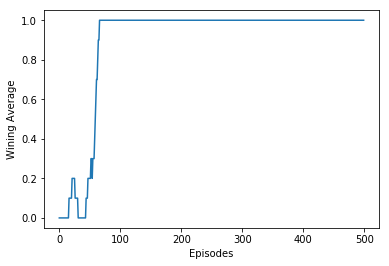

<IPython.core.display.Math object>

[[0.        0.59049   0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.6561    0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.6456361 0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.729     0.       ]
 [0.        0.        0.81      0.       ]
 [0.        0.9       0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.6912    0.       ]
 [0.        0.        1.        0.       ]
 [0.        0.        0.        0.       ]]


<IPython.core.display.Math object>

[[0.59049   0.        0.        0.       ]
 [0.6561    0.        0.6456361 0.       ]
 [0.729     0.81      0.9       0.       ]
 [0.        0.6912    1.        0.       ]]


<IPython.core.display.Math object>

[['D' 'X' 'X' 'X']
 ['D' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'R' 'R' 'X']]


In [13]:
# Si 'y' es bajo, los valores de Q tardan mas en pasar 
# np.random.randn(1,env.action_space.n)*(1./(i+1))
num_episodes = 500
Q_ns_table_1, acummulated_average_ns_table_1, _ = estimate_Q(env_not_slippery, 
                                           num_episodes=num_episodes, 
                                           y = 0.9, MA_window = 10, debug=False)
show_results(Q_ns_table_1, acummulated_average_ns_table_1)

### y=0.25

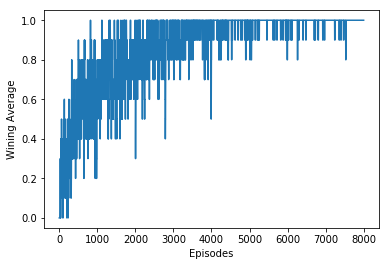

<IPython.core.display.Math object>

[[1.13906250e-05 7.59375000e-05 7.59375000e-05 1.13906250e-05]
 [1.13906250e-05 0.00000000e+00 5.06250000e-04 7.59375000e-05]
 [7.59375000e-05 3.37500000e-03 7.59375000e-05 5.06250000e-04]
 [5.06250000e-04 0.00000000e+00 7.59374996e-05 7.59374957e-05]
 [7.59375000e-05 5.06250000e-04 0.00000000e+00 1.13906250e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.25000000e-02 0.00000000e+00 4.51448640e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.06250000e-04 0.00000000e+00 3.37500000e-03 7.59375000e-05]
 [0.00000000e+00 2.25000000e-02 2.25000000e-02 0.00000000e+00]
 [0.00000000e+00 1.50000000e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.50000000e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

<IPython.core.display.Math object>

[[7.59375e-05 5.06250e-04 3.37500e-03 5.06250e-04]
 [5.06250e-04 0.00000e+00 2.25000e-02 0.00000e+00]
 [3.37500e-03 2.25000e-02 1.50000e-01 0.00000e+00]
 [0.00000e+00 1.50000e-01 1.00000e+00 0.00000e+00]]


<IPython.core.display.Math object>

[['D' 'R' 'D' 'L']
 ['D' 'H' 'D' 'H']
 ['R' 'D' 'D' 'H']
 ['H' 'R' 'R' 'X']]


In [14]:
# Si 'y' es bajo, los valores de Q tardan mas en pasar 'np.random.randn(1,env.action_space.n)*(1./(i+1))'
# Por lo tanto se prueban mas opciones.
# Se confia menos en las recompenzas futuras

num_episodes = 8000
Q_ns_table_2, acummulated_average_ns_table_2, _ = estimate_Q(env_not_slippery, 
                                           num_episodes=num_episodes, 
                                           y = 0.15, MA_window = 10, debug=False)
show_results(Q_ns_table_2, acummulated_average_ns_table_2)

# Slippery

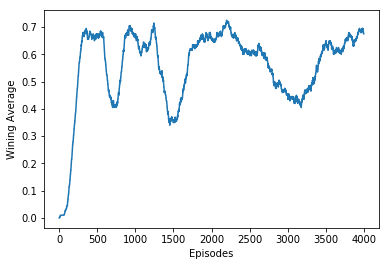

<IPython.core.display.Math object>

[[1.34640238e-01 5.61009769e-03 5.57932351e-03 6.20667222e-03]
 [1.14444358e-03 1.38509717e-03 4.85817400e-04 2.73421367e-01]
 [1.00451230e-03 1.44200058e-01 1.06187864e-03 2.34339354e-03]
 [0.00000000e+00 4.34259235e-04 6.03606019e-04 8.55007835e-02]
 [2.44883052e-01 5.96964701e-04 8.11960854e-04 3.19083142e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.05378644e-01 6.19180689e-05 3.41039615e-04 5.43214891e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.68670490e-03 3.40137394e-03 0.00000000e+00 1.59023166e-01]
 [0.00000000e+00 4.15462120e-01 1.03114983e-03 0.00000000e+00]
 [5.00146298e-02 2.45935658e-04 0.00000000e+00 2.45448198e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.80944640e-03 0.00000000e+00 7.82874131e-01 4.86400000e-03]
 [0.00000000e+00 0.00000000e+00 9.79148938e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

<IPython.core.display.Math object>

[[0.13464024 0.27342137 0.14420006 0.08550078]
 [0.24488305 0.         0.10537864 0.        ]
 [0.15902317 0.41546212 0.05001463 0.        ]
 [0.         0.78287413 0.97914894 0.        ]]


<IPython.core.display.Math object>

[['L' 'U' 'D' 'U']
 ['L' 'H' 'L' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'R' 'X']]


In [15]:
# Si y es bajo, los valores de Q tardan mas en pasar 
# np.random.randn(1,env.action_space.n)*(1./(i+1))
num_episodes = 4000
Q_s_table, acummulated_average_s_table, _ = estimate_Q(env, 
                                           num_episodes=num_episodes, 
                                           y = 0.95, MA_window = 200, debug=False)
show_results(Q_s_table, acummulated_average_s_table)

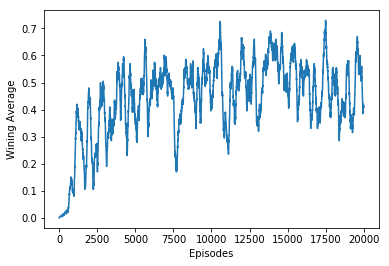

<IPython.core.display.Math object>

[[1.12169361e-04 4.71430023e-03 4.81319789e-05 9.90880969e-05]
 [3.03348992e-05 2.33245566e-05 2.84082682e-05 9.89669258e-04]
 [2.22240823e-04 6.53695362e-04 2.80881614e-05 5.78543324e-05]
 [2.56679973e-06 8.62562886e-06 6.20806122e-06 2.61073041e-03]
 [1.67788469e-02 3.58429385e-05 2.96517601e-07 1.76540865e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.32711942e-04 7.59369757e-07 3.12148991e-05 2.57693760e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.25321383e-05 1.26250378e-05 1.98351760e-05 1.58112294e-01]
 [3.58331747e-05 4.16911756e-01 0.00000000e+00 3.55704196e-05]
 [7.52740948e-01 2.09449796e-04 1.69998829e-04 1.71907178e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.29812534e-03 5.28792830e-01 8.35953213e-04]
 [0.00000000e+00 9.08162565e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

<IPython.core.display.Math object>

[[4.71430023e-03 9.89669258e-04 6.53695362e-04 2.61073041e-03]
 [1.67788469e-02 0.00000000e+00 1.32711942e-04 0.00000000e+00]
 [1.58112294e-01 4.16911756e-01 7.52740948e-01 0.00000000e+00]
 [0.00000000e+00 5.28792830e-01 9.08162565e-01 0.00000000e+00]]


<IPython.core.display.Math object>

[['D' 'U' 'D' 'U']
 ['L' 'H' 'L' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'D' 'X']]


In [16]:
num_episodes = 20000
Q_s_table_1, acummulated_average_s_table_1, _ = estimate_Q(env, 
                                           num_episodes=num_episodes, 
                                           y = 0.8, MA_window = 200, debug=False)
show_results(Q_s_table_1, acummulated_average_s_table_1)

# Neural Network Q aproximation

- Entrada: ont-hot 1x16
- Capa densa con 14x4 pasos
- Salida: L, D, R, U

Algoritmo:
- Inicializo pesos de la red neuronal aleatoriamente
- Ingreso con el estado inicial $s_0$
- Me devuelve un listado de posibles acciones con sus pesos: $q(s_0, a)$
- Elijo la accion mas probable a_0 (Con un grado de aleatoriedad que va disminuyendo con cada episodio) y guardo el valor $maxQ_0$ (valor de Q para esa accion)
- Ejecuto la accion y tengo un nuevo estado $S_1$ con un posible reward $r_1$
- Ingreso a la RNN con ese nuevo estado, obtengo $q(s_1,a)$ y me quedo con el valor mayor ($maxQ_1$)
- Uso $maxQ_1$ para predecir el anterior $maxQ_0$: $r_1+\gamma maxQ_1$
- Es decir, le pido que haga un update de los pesos con entrada $s_0$ y salida $maxQ_0$ (Target, valor anotado)
- Repito esto hasta que termina el juego (suponiendo que termina)
- repito esto tantos episodios como sean necesarios

In [17]:
def estimate_NN_Q(env, num_episodes = 4000, y = .99, MA_window = 400, lr=0.1, random_bias=10, inv_sigma = 50):
    tf.reset_default_graph()
    #These lines establish the feed-forward part of the network used to choose actions
    inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
    W = tf.Variable(tf.random_uniform([16,4],0,0.01))
    Qout = tf.matmul(inputs1,W)
    predict = tf.argmax(Qout,1)

    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    #trainer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    trainer = tf.train.AdamOptimizer()
    updateModel = trainer.minimize(loss)
    init = tf.global_variables_initializer()
    acummulated_average = []
    #create lists to contain total rewards and steps per episode
    jList = []
    rList = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_episodes):
            #Reset environment and get first new observation
            s = env.reset()
            rAll = 0
            d = False
            j = 0
            #The Q-Network
            while j < 99:
                j+=1
                #Choose an action by greedily (with e chance of random action) from the Q-network
                a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
                #a no lo estoy usando. Solo uso allQ que es la Q para el estado s de todas las acciones posibles

                a = np.argmax(allQ + np.random.randn(1,env.action_space.n)*(1./((i/inv_sigma) + random_bias)))
                a = np.array([a])
                #en a esta la proxima accion
                #Get new state and reward from environment
                s1,r,d,_ = env.step(a[0])
                #Obtain the Q' values by feeding the new state through our network
                Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
                #Obtain maxQ' and set our target value for chosen action.
                maxQ1 = np.max(Q1)
                targetQ = allQ
                targetQ[0,a[0]] = r + y*maxQ1
                #Train our network using target and predicted Q values
                _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
                rAll += r
                s = s1
                if d == True:
                    break
            jList.append(j)
            rList.append(rAll)
            acummulated_average.append(float(sum(rList[-MA_window:]))/MA_window)
        Q = []
        for i in range(16):
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[i:i+1]})
            Q.append(allQ[0])
        Q = np.array(Q)
    return Q, acummulated_average, rList

# Slippery

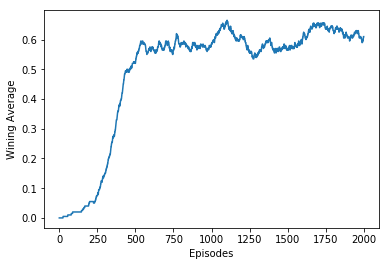

<IPython.core.display.Math object>

[[ 4.49360311e-01  3.67683202e-01  2.86778182e-01  2.13670701e-01]
 [ 5.14550768e-02  3.52175497e-02  5.55901937e-02  3.38289440e-01]
 [ 8.90316367e-02  1.21380985e-01  9.02374238e-02  2.79363632e-01]
 [ 4.45880890e-02  2.75567714e-02  2.15739962e-02  2.52398580e-01]
 [ 4.59325790e-01  1.50882527e-02  3.12093794e-02  1.21322013e-02]
 [ 3.67537490e-03  4.53436701e-03  7.99832342e-04  6.71575032e-03]
 [ 9.39638540e-02  7.80285709e-03  5.16301766e-02  1.05507104e-02]
 [ 3.31669790e-03  4.84690652e-04  2.37805001e-03  7.87414331e-03]
 [ 1.47341564e-02  2.38266978e-02  4.90332618e-02  4.77154642e-01]
 [ 1.59636326e-02  5.37750900e-01 -3.86898569e-03  1.86241753e-02]
 [ 1.39159217e-01  4.57314283e-01 -1.44418832e-02 -5.60067873e-03]
 [ 2.99386971e-04  6.81308506e-04  1.20922923e-03  5.18490560e-03]
 [ 9.34680831e-03  7.72712228e-04  7.45136710e-03  3.17475665e-03]
 [ 8.77912901e-03  9.98160522e-03  6.90257788e-01  1.29817484e-03]
 [ 3.09579000e-02  8.44570637e-01  6.76860288e-02  6.21327758e

<IPython.core.display.Math object>

[[0.4493603  0.33828944 0.27936363 0.25239858]
 [0.4593258  0.00671575 0.09396385 0.00787414]
 [0.47715464 0.5377509  0.45731428 0.00518491]
 [0.00934681 0.6902578  0.84457064 0.00875727]]


<IPython.core.display.Math object>

[['L' 'U' 'U' 'U']
 ['L' 'H' 'L' 'H']
 ['U' 'D' 'D' 'H']
 ['H' 'R' 'D' 'D']]


In [18]:
# notar aca el random_bias = 50. 
Q_nn_s, acummulated_average_nn_s, _ = estimate_NN_Q(env, num_episodes = 2000, 
                                                    y = .99, 
                                                    MA_window = 200, 
                                                    lr=0.05,
                                                   random_bias=50)
show_results(Q_nn_s, acummulated_average_nn_s)

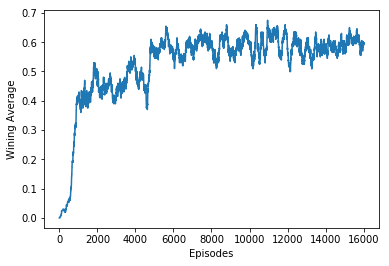

<IPython.core.display.Math object>

[[ 6.09488897e-02  1.18947187e-02  1.33225303e-02  1.76893052e-04]
 [-1.21787945e-02 -4.06632945e-03 -1.94393937e-02  5.31973653e-02]
 [ 4.94669788e-02 -8.94333352e-04  4.56568552e-03  1.03376303e-02]
 [ 4.50255116e-03  6.90220157e-03 -4.59808158e-03  2.84253452e-02]
 [ 7.71996602e-02  1.70286521e-02  7.98745733e-03 -2.75602448e-03]
 [ 1.55087706e-04  5.80441952e-03  5.69954142e-03  9.52216052e-03]
 [-7.39993155e-03  1.22212516e-02  5.95006682e-02  1.49788545e-03]
 [ 3.03472159e-03  3.13612935e-03  6.97110780e-03  7.05799786e-03]
 [ 4.33495920e-03  1.79725178e-02  1.88028980e-02  1.44420356e-01]
 [ 1.96759566e-03  2.26205900e-01  2.08010674e-02  7.60745630e-03]
 [ 2.25933522e-01  3.49213742e-02  1.37982843e-02 -8.17843073e-04]
 [ 3.87815945e-03  8.70422111e-04  1.35620229e-03  3.74375936e-03]
 [ 4.80922824e-03  9.41114128e-03  9.60088801e-03  6.55162102e-03]
 [ 2.52705277e-03  1.87413453e-03  3.08813304e-01  4.06033359e-02]
 [ 9.21406038e-03  2.53507718e-02 -5.09759528e-04  5.20618975e

<IPython.core.display.Math object>

[[0.06094889 0.05319737 0.04946698 0.02842535]
 [0.07719966 0.00952216 0.05950067 0.007058  ]
 [0.14442036 0.2262059  0.22593352 0.00387816]
 [0.00960089 0.3088133  0.520619   0.00981642]]


<IPython.core.display.Math object>

[['L' 'U' 'L' 'U']
 ['L' 'H' 'R' 'H']
 ['U' 'D' 'L' 'H']
 ['H' 'R' 'U' 'R']]


In [19]:
# notar aca el random_bias = 50. 
Q_nn_s, acummulated_average_nn_s, _ = estimate_NN_Q(env, num_episodes = 16000, 
                                                    y = .9, 
                                                    MA_window = 200, 
                                                    lr=0.05,
                                                   random_bias=100,
                                                   inv_sigma = 30)
show_results(Q_nn_s, acummulated_average_nn_s)

# Non-slippery

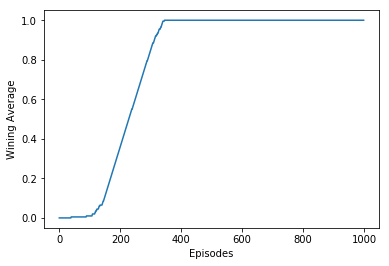

<IPython.core.display.Math object>

[[ 9.4781977e-01  9.5879143e-01  5.1194876e-01  9.4772887e-01]
 [ 5.4099149e-01 -4.8843557e-03  5.0118345e-01  4.1278210e-01]
 [ 4.7843874e-01  5.0712776e-01  3.1780154e-01  4.6411636e-01]
 [ 3.5095629e-01 -4.0820674e-03  2.3567589e-01  3.0378035e-01]
 [ 9.5898247e-01  9.6902424e-01  1.9284504e-03  6.4406794e-01]
 [ 9.7436439e-03  3.8555551e-03  3.8781059e-03  3.5723674e-03]
 [-3.2652233e-04  5.3525525e-01 -5.1119039e-03  4.6225986e-01]
 [ 2.7625787e-03  3.4164786e-04  7.4404511e-03  6.3052699e-03]
 [ 5.2523547e-01  3.2974411e-05  9.7826165e-01  5.0375241e-01]
 [ 3.0832911e-01 -5.7783984e-03  9.8838294e-01  1.8750770e-02]
 [ 3.5409063e-01  9.9857771e-01 -6.1203141e-06  3.2598141e-01]
 [ 8.0566462e-03  8.9959307e-03  5.7317447e-03  5.8566127e-03]
 [ 5.1738261e-03  2.6598047e-03  4.2738030e-03  5.0788294e-03]
 [-2.2711752e-03  2.3597121e-04  1.7214906e-03  4.1439496e-02]
 [ 6.2110508e-03  6.8627425e-02  1.0084835e+00  6.9289699e-02]
 [ 3.0680464e-03  1.9883192e-03  4.6966039e-03  8.57127

<IPython.core.display.Math object>

[[0.95879143 0.5409915  0.50712776 0.3509563 ]
 [0.96902424 0.00974364 0.53525525 0.00744045]
 [0.97826165 0.98838294 0.9985777  0.00899593]
 [0.00517383 0.0414395  1.0084835  0.00857128]]


<IPython.core.display.Math object>

[['D' 'L' 'D' 'L']
 ['D' 'H' 'D' 'H']
 ['R' 'R' 'D' 'H']
 ['H' 'U' 'R' 'U']]


In [20]:
Q_nn_ns, acummulated_average_nn_ns, _ = estimate_NN_Q(env_not_slippery, 
                                                      num_episodes = 1000, 
                                                      y = .99,
                                                      MA_window = 200, 
                                                      lr=0.1)
show_results(Q_nn_ns, acummulated_average_nn_ns)

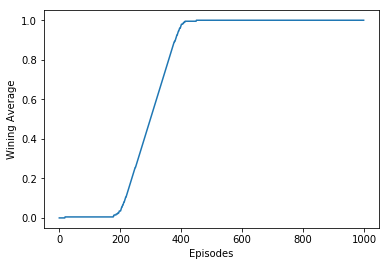

<IPython.core.display.Math object>

[[-2.1839957e-03 -1.0511522e-02  3.1355426e-02 -2.9717498e-03]
 [ 2.2485179e-03  2.5587890e-03  6.2715158e-02  8.0810711e-03]
 [-2.2393500e-03  1.2542911e-01  3.4344944e-03 -1.9877279e-02]
 [ 5.1414575e-03  5.3152572e-03 -1.5972823e-02 -1.3428799e-02]
 [-5.0057494e-03  1.7787976e-02  2.5828823e-03 -9.8226964e-03]
 [ 1.6792560e-03  2.1495617e-03  5.1192748e-03  3.9739618e-03]
 [-1.3291491e-02  2.5085843e-01 -1.4783179e-02 -5.6746094e-03]
 [ 3.1336665e-03  7.6454412e-03  4.6090325e-03  6.4753196e-03]
 [-1.7611822e-02 -6.0905260e-03 -1.9347006e-03 -1.6833064e-03]
 [-6.0514295e-03 -9.2518413e-03 -3.1852364e-03  1.2089184e-02]
 [-5.3163180e-03  5.0171709e-01 -4.7461549e-03 -8.8013122e-03]
 [ 9.4380137e-04  2.7566324e-03  6.9711050e-03  6.8876515e-03]
 [ 5.5345879e-03  6.1376989e-03  2.2421323e-03  1.7327940e-03]
 [-2.7062872e-03 -7.6009273e-03 -2.0498489e-03  1.5087678e-02]
 [ 1.1960904e-03  3.2367758e-02  1.0034343e+00  8.5951324e-04]
 [ 3.4843576e-03  3.9849542e-03  5.4719020e-03  7.04924

<IPython.core.display.Math object>

[[ 0.03135543  0.06271516  0.12542911  0.00531526]
 [ 0.01778798  0.00511927  0.25085843  0.00764544]
 [-0.00168331  0.01208918  0.5017171   0.00697111]
 [ 0.0061377   0.01508768  1.0034343   0.00704925]]


<IPython.core.display.Math object>

[['R' 'R' 'D' 'D']
 ['D' 'H' 'D' 'H']
 ['U' 'U' 'D' 'H']
 ['H' 'U' 'R' 'U']]


In [21]:
Q_nn_ns, acummulated_average_nn_ns, _ = estimate_NN_Q(env_not_slippery, 
                                                      num_episodes = 1000, 
                                                      y = .5,
                                                      MA_window = 200, 
                                                      lr=0.1,
                                                     random_bias=200)
show_results(Q_nn_ns, acummulated_average_nn_ns)